In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('../../data/census_bureau_acs.csv')
df.head()

,geo_id,total_pop,income_per_capita,income_less_10000,income_10000_14999,income_15000_19999,income_20000_24999,income_25000_29999,income_30000_34999,income_35000_39999,income_40000_44999,income_45000_49999,income_50000_59999,income_60000_74999,income_75000_99999,income_100000_124999,income_125000_149999,income_150000_199999,income_200000_or_more
0,5,2990671.0,25635.0,93423.0,74534.0,70617.0,73576.0,69556.0,65675.0,61375.0,60069.0,51743.0,95124.0,111457.0,124254.0,78338.0,44816.0,39928.0,37690.0
1,2,738516.0,35874.0,10230.0,7609.0,7962.0,8567.0,8830.0,8897.0,8630.0,9759.0,8172.0,18000.0,27311.0,36073.0,29553.0,20043.0,23692.0,20134.0
2,10,949495.0,33989.0,19901.0,12769.0,12490.0,15416.0,15365.0,16843.0,15105.0,14978.0,13875.0,27672.0,36996.0,50512.0,34311.0,22450.0,25568.0,23514.0
3,48,27885195.0,30143.0,609111.0,415778.0,431000.0,454863.0,460236.0,456584.0,419784.0,431876.0,372502.0,753148.0,942058.0,1168213.0,839610.0,552446.0,588275.0,657562.0
4,16,1687809.0,26772.0,38492.0,29568.0,29865.0,33635.0,31268.0,34988.0,32391.0,31324.0,28244.0,54943.0,70028.0,76641.0,51057.0,28311.0,25253.0,22323.0


## Mean income in the US:

In [3]:
# calculating mean income in the US
mean_income_us = sum(df['total_pop']*df['income_per_capita'])/df['total_pop'].sum()
print(f'Mean income in the US >> ${round(mean_income_us, 2)}')

Mean income in the US >> $32411.26


In [4]:
# transforming table for Mean and Median estimation
state_name_map = {48: 'TX', 12: 'FL', 36: 'NY', 6: 'CA'}

# getting mean income data across the country
df1 = df.T.drop(['total_pop', 'income_per_capita', 'geo_id'], axis=0)
df1['US'] = round(df1.sum(axis=1)/df1.count(axis=1), 2)

geoid = ['06', '36', '48', '12']
df = df[df['geo_id'].isin(geoid)].drop(['total_pop', 'income_per_capita'], axis=1).set_index('geo_id')
df = df.T.rename(columns=state_name_map)
df = pd.concat([df, df1['US']], axis=1)

In [5]:
df

,TX,FL,NY,CA,US
income_less_10000,609111.0,520876.0,492408.0,656515.0,152258.65
income_10000_14999,415778.0,360160.0,378399.0,573531.0,108662.52
income_15000_19999,431000.0,389340.0,325767.0,499894.0,107902.96
income_20000_24999,454863.0,410675.0,318683.0,536077.0,110679.69
income_25000_29999,460236.0,410787.0,301819.0,510114.0,108419.00
income_30000_34999,456584.0,402990.0,300327.0,513108.0,108203.33
income_35000_39999,419784.0,382842.0,275108.0,480115.0,100934.96
income_40000_44999,431876.0,377521.0,279709.0,495884.0,102368.46
income_45000_49999,372502.0,331613.0,243067.0,439574.0,90276.25
income_50000_59999,753148.0,630925.0,492299.0,880868.0,176957.15


## Mathematical derivation of Median and Mean income by state

In [8]:
# helper function that creates all necessary transformations for Mean, Median and Skew estimation
def df_estimate_transform(dataframe, state_list):
    dataframe = dataframe.reset_index()
    dataframe['index'] = dataframe['index'].str.replace('income_', '').str.replace('less', '0').str.replace('or_more', '500000').str.replace('_', '-')
    dataframe['bin_lower'] = dataframe['index'].apply(lambda x: x.split('-')[0]).astype(int)
    dataframe['bin_upper'] = dataframe['index'].apply(lambda x: x.split('-')[1]).astype(int)
    dataframe['bin_mean'] = (dataframe['bin_upper'] + dataframe['bin_lower'])/2
    dataframe['bin_width'] = dataframe['bin_upper'] - dataframe['bin_lower']
    dataframe['bin_width_norm'] = round(dataframe['bin_width']/min(dataframe['bin_width']))

    # adding new calculated columns
    for state in state_list:
        # calculating histogram height for each state and bin
        dataframe[f'{state}_hist'] = round(dataframe[f'{state}']/dataframe['bin_width_norm'], 2)
        # calculating cumulative areas under the histogram
        dataframe[f'{state}_cumul_area'] = dataframe[f'{state}'].cumsum().tolist()
        # calculating cumulative percentage
        dataframe[f'{state}_percentile'] = round(dataframe[f'{state}'].cumsum()*100/dataframe[f'{state}'].sum(), 2)
        
    return dataframe

In [9]:
state_list = ['TX', 'CA', 'NY', 'FL', 'US']
df = df_estimate_transform(df, state_list)
df

,index,TX,FL,NY,CA,US,bin_lower,bin_upper,bin_mean,bin_width,...,CA_percentile,NY_hist,NY_cumul_area,NY_percentile,FL_hist,FL_cumul_area,FL_percentile,US_hist,US_cumul_area,US_percentile
0,0-10000,609111.0,520876.0,492408.0,656515.0,152258.65,0,10000,5000.0,10000,...,5.06,246204.0,492408.0,6.73,260438.00,520876.0,6.83,76129.32,152258.65,6.55
1,10000-14999,415778.0,360160.0,378399.0,573531.0,108662.52,10000,14999,12499.5,4999,...,9.49,378399.0,870807.0,11.90,360160.00,881036.0,11.56,108662.52,260921.17,11.22
2,15000-19999,431000.0,389340.0,325767.0,499894.0,107902.96,15000,19999,17499.5,4999,...,13.34,325767.0,1196574.0,16.35,389340.00,1270376.0,16.67,107902.96,368824.13,15.86
3,20000-24999,454863.0,410675.0,318683.0,536077.0,110679.69,20000,24999,22499.5,4999,...,17.48,318683.0,1515257.0,20.71,410675.00,1681051.0,22.06,110679.69,479503.82,20.62
4,25000-29999,460236.0,410787.0,301819.0,510114.0,108419.00,25000,29999,27499.5,4999,...,21.41,301819.0,1817076.0,24.84,410787.00,2091838.0,27.45,108419.00,587922.82,25.28
5,30000-34999,456584.0,402990.0,300327.0,513108.0,108203.33,30000,34999,32499.5,4999,...,25.37,300327.0,2117403.0,28.94,402990.00,2494828.0,32.73,108203.33,696126.15,29.93
6,35000-39999,419784.0,382842.0,275108.0,480115.0,100934.96,35000,39999,37499.5,4999,...,29.07,275108.0,2392511.0,32.70,382842.00,2877670.0,37.76,100934.96,797061.11,34.27
7,40000-44999,431876.0,377521.0,279709.0,495884.0,102368.46,40000,44999,42499.5,4999,...,32.90,279709.0,2672220.0,36.52,377521.00,3255191.0,42.71,102368.46,899429.57,38.67
8,45000-49999,372502.0,331613.0,243067.0,439574.0,90276.25,45000,49999,47499.5,4999,...,36.29,243067.0,2915287.0,39.85,331613.00,3586804.0,47.06,90276.25,989705.82,42.56
9,50000-59999,753148.0,630925.0,492299.0,880868.0,176957.15,50000,59999,54999.5,9999,...,43.08,246149.5,3407586.0,46.57,315462.50,4217729.0,55.34,88478.58,1166662.97,50.16


In [10]:
# function for estimating Mean, Median and Skew by state
def mean_med_skew(state_abbrev):
#     calculating the range that the median falls in
#     current_bin - index of lower limit of the bin where the median falls
    print('='*60)
    print(state_abbrev)
    print('='*60)
    current_bin = 0
    cumul_areas = df[f'{state_abbrev}_cumul_area'].tolist()
    for ind, num in enumerate(cumul_areas):
#         area under histogram on both sides of the median
        median_area = df[f'{state_abbrev}'].sum()/2 
        if median_area >= num:
            current_bin = ind+1
            cumul_area = num
    bin_bottom_income = df['bin_lower'].tolist()[current_bin]
#     remaining area 
    residual_area = median_area - cumul_area

    current_bin_width = df['bin_width'].tolist()[current_bin]
    current_bin_freq = df[f'{state_abbrev}'].tolist()[current_bin]
    residual_len = (current_bin_width * residual_area)/current_bin_freq

#     HELPER PLOTS FOR DEBUGGING
#     print(f'Area under histogram on the sides of the median is {median_area}')
#     print(f'Median falls into bin #{current_bin}')
#     print(f'Bottom income for the bin is {bin_bottom_income}')
#     print(f'Cumulative area on the left the bin lower limit is {cumul_area}')
#     print(f'The residual area under the histogram is {residual_area}')
#     print(f'The residual length from bottom range of the bin is {round(residual_len, 2)}')

    median_income = bin_bottom_income + residual_len
    mean_income = round((df['bin_mean']*df[f'{state_abbrev}_hist']).sum()/df[f'{state_abbrev}'].sum(), 2) 
    skew = df[f'{state_abbrev}_hist'].skew()
    
    print(f'Mean income per household in {state_abbrev} >> ${round(mean_income, 2)}') 
    print(f'Median income per household in {state_abbrev} >> ${round(median_income, 2)}')
    print(f'Skew for {state_abbrev} >> {round(skew, 2)}')
    
    return({'mean': mean_income,
            'median': median_income,
            'skew': skew        
    })

## Mean and Median annual household income in Texas, California, New York and Florida

In [11]:
for state in state_list:
    mean_med_skew(state)

TX
Mean income per household in TX >> $22437.47
Median income per household in TX >> $59622.5
Skew for TX >> -0.91
CA
Mean income per household in CA >> $21433.21
Median income per household in CA >> $71358.89
Skew for CA >> -0.96
NY
Mean income per household in NY >> $21248.75
Median income per household in NY >> $65797.35
Skew for NY >> -0.74
FL
Mean income per household in FL >> $22951.47
Median income per household in FL >> $53551.19
Skew for FL >> -0.77
US
Mean income per household in US >> $22275.27
Median income per household in US >> $59782.9
Skew for US >> -0.92


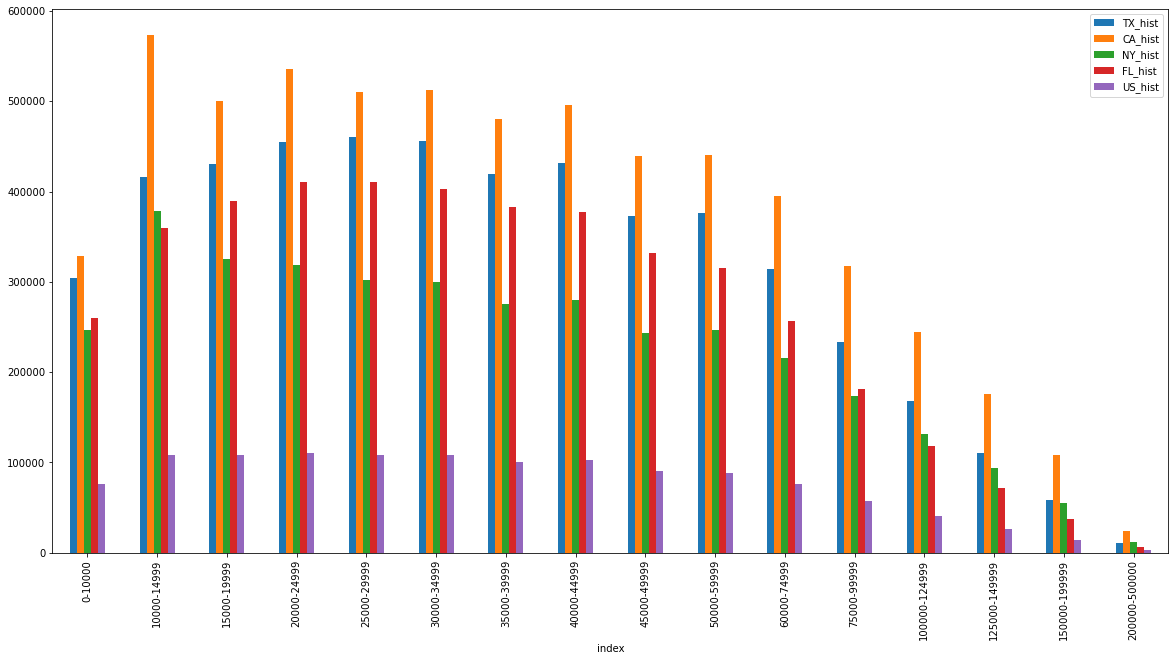

In [12]:
hist_cols = [col for col in df.columns if 'hist' in col]
df[hist_cols+['index']].set_index('index').plot.bar(figsize=(20,10))

## Percentile graphs

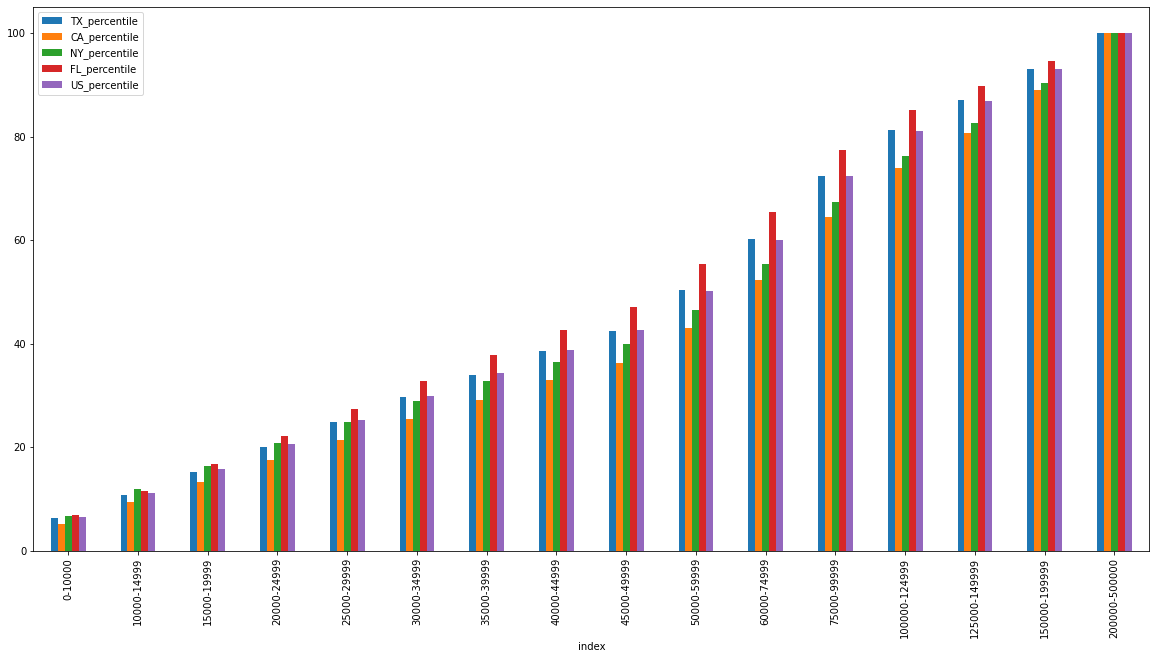

In [13]:
# plotting percentile graphs
percent_cols = [col for col in df.columns if 'percentile' in col]

df[percent_cols+['index']].set_index('index').plot.bar(figsize=(20,10))

In [22]:
df = pd.read_csv('../../data/census_bureau_acs_2013-2018.csv')
df

,geo_id,do_date,total_pop,income_per_capita,income_less_10000,income_10000_14999,income_15000_19999,income_20000_24999,income_25000_29999,income_30000_34999,income_35000_39999,income_40000_44999,income_45000_49999,income_50000_59999,income_60000_74999,income_75000_99999,income_100000_124999,income_125000_149999,income_150000_199999,income_200000_or_more
0,30,2013,1015165.0,26054.0,31743.0,26612.0,23449.0,27461.0,21685.0,24538.0,18534.0,21642.0,18217.0,34893.0,45065.0,44491.0,30157.0,13357.0,11804.0,12640.0
1,50,2013,626630.0,29136.0,15806.0,16774.0,13319.0,13049.0,12567.0,13989.0,11397.0,11367.0,10717.0,22421.0,26125.0,34531.0,20262.0,9772.0,11459.0,9679.0
2,38,2013,723393.0,30855.0,20189.0,14362.0,11768.0,16158.0,15376.0,16175.0,12942.0,15791.0,11841.0,23246.0,30574.0,43860.0,26449.0,13610.0,13479.0,12478.0
3,46,2013,844877.0,25860.0,21013.0,18765.0,16985.0,17607.0,20568.0,18219.0,19270.0,20865.0,15657.0,30238.0,36296.0,42096.0,22482.0,10793.0,8393.0,12159.0
4,72,2013,3615086.0,11208.0,367080.0,148683.0,130258.0,105044.0,80210.0,73524.0,55373.0,49026.0,36967.0,58504.0,53838.0,44695.0,21755.0,10788.0,9511.0,8434.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,17,2018,12741080.0,35801.0,309799.0,187148.0,196778.0,230715.0,199822.0,212845.0,191290.0,198978.0,174986.0,348760.0,488167.0,607741.0,465929.0,297668.0,352091.0,402147.0
308,51,2018,8517685.0,38900.0,166161.0,115412.0,114457.0,121666.0,117078.0,119690.0,115397.0,124891.0,117099.0,215019.0,302261.0,406431.0,308544.0,222485.0,267953.0,340980.0
309,34,2018,8908520.0,42815.0,160863.0,100237.0,114845.0,119681.0,105619.0,113081.0,106240.0,101910.0,94438.0,196703.0,285234.0,397522.0,326712.0,243495.0,329913.0,453074.0
310,32,2018,3034392.0,31604.0,74368.0,41667.0,44630.0,53460.0,47139.0,58742.0,51823.0,59290.0,50181.0,92355.0,115225.0,150362.0,103695.0,60008.0,66152.0,60713.0


In [23]:
# helper function for transforming initial table for Mean, Median and Skew estimation
def df_transform(dataframe, year):  
    dataframe = dataframe[dataframe['do_date'] == year]
    dataframe = dataframe[dataframe['geo_id'].isin(geoid)]
    dataframe = dataframe.set_index('geo_id').T.drop(['total_pop', 'income_per_capita', 'do_date'], axis=0).rename(columns=state_name_map)
    dataframe['year'] = year
    return dataframe

In [24]:
df_2013 = df_transform(df, 2013)
df_2014 = df_transform(df, 2014)
df_2015 = df_transform(df, 2015)
df_2016 = df_transform(df, 2016)
df_2017 = df_transform(df, 2017)
df_2018 = df_transform(df, 2018)

In [25]:
df_2018

geo_id,NY,CA,FL,TX,year
income_less_10000,503909.0,670677.0,511203.0,632765.0,2018
income_10000_14999,357629.0,515804.0,351037.0,416618.0,2018
income_15000_19999,310940.0,456076.0,377751.0,413164.0,2018
income_20000_24999,325741.0,520133.0,413800.0,468286.0,2018
income_25000_29999,277816.0,458689.0,381721.0,429986.0,2018
income_30000_34999,293279.0,485094.0,404479.0,463483.0,2018
income_35000_39999,263872.0,458942.0,378096.0,423227.0,2018
income_40000_44999,264265.0,477566.0,365568.0,422627.0,2018
income_45000_49999,245075.0,425951.0,339901.0,393871.0,2018
income_50000_59999,486211.0,840945.0,636955.0,764659.0,2018


In [26]:
state_list = ['TX', 'CA', 'NY', 'FL']
df_2013 = df_estimate_transform(df_2013, state_list)
df_2014 = df_estimate_transform(df_2014, state_list)
df_2015 = df_estimate_transform(df_2015, state_list)
df_2016 = df_estimate_transform(df_2016, state_list)
df_2017 = df_estimate_transform(df_2017, state_list)
df_2018 = df_estimate_transform(df_2018, state_list)

In [27]:
df_2013_2018 = pd.concat([df_2013, df_2014, df_2015, df_2016, df_2017, df_2018], axis=0)

In [28]:
tx_cols = [col for col in df_2013_2018 if 'TX' in col]
tx_cols

['TX', 'TX_hist', 'TX_cumul_area', 'TX_percentile']

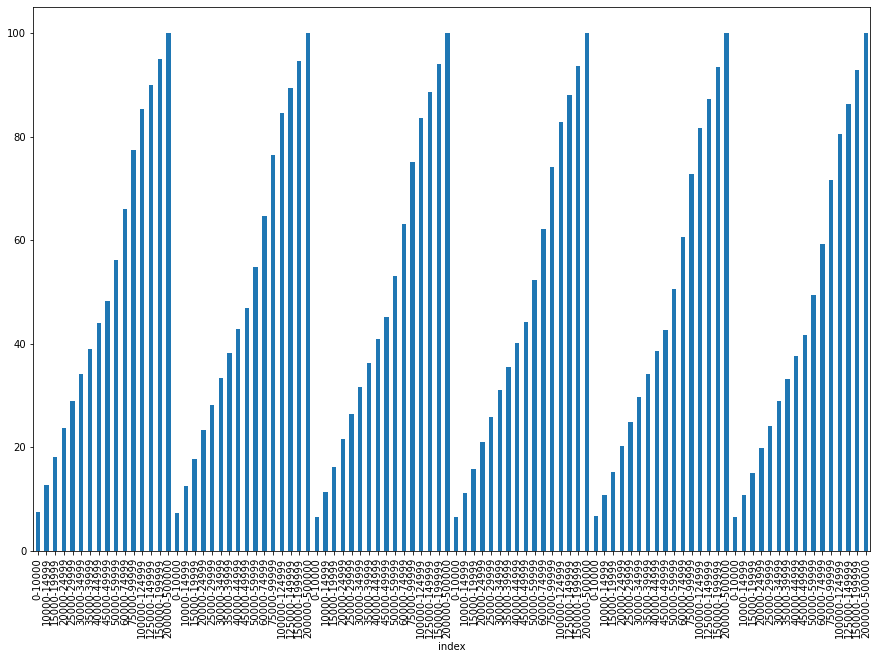

In [57]:
percent_cols = [col for col in df.columns if 'TX_percentile' in col]

df_2013_2018.set_index('index')['TX_percentile'].plot.bar(figsize=(15,10))